In [1]:
from typing import Dict, Optional, Tuple
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision.datasets import Flowers102
from torchvision import transforms
from torchvision.utils import save_image, make_grid

from mindiffusion.unet import NaiveUnet
from mindiffusion.ddpm import DDPM

import matplotlib.pyplot as plt

# список изменений в коде: батчи по памяти, воркеры, датасет из торча

In [34]:
def train_Flowers102(
    n_epoch: int = 1000, device: str = "cuda:0", load_pth: Optional[str] = None 
) -> None:

    ddpm = DDPM(eps_model=NaiveUnet(3, 3, n_feat=128), betas=(1e-4, 0.02), n_T=1000) # 3 входных канала, 3 выходных, 128 фич, значения беты и количество шагов, как из ориганльной статьи

    if load_pth is not None:
        ddpm.load_state_dict(torch.load("ddpm_Flowers.pth"))

    ddpm.to(device)

    tf = transforms.Compose([ 
        transforms.ToTensor(), 
        transforms.Resize([64,64]), # добален ресайз
        transforms.Normalize([0.5], [0.5])])   # были чиселки [0,255] -> [-1,1], теперь как в оригинальной статье

    dataset = Flowers102(
        "./data",
        download=True,
        transform=tf,
    )

    dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4) 
    optim = torch.optim.Adam(ddpm.parameters(), lr=1e-5)

    for i in range(n_epoch):
        print(f"Epoch {i} : ")
        
        ddpm.train()

        pbar = tqdm(dataloader)
        loss_ema = None
        for x, _ in pbar:
            optim.zero_grad()
            x = x.to(device)
            loss = ddpm(x)
            loss.backward()
            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.9 * loss_ema + 0.1 * loss.item()
            pbar.set_description(f"loss: {loss_ema:.4f}")
            optim.step()

        ddpm.eval()
        with torch.no_grad():
            xh = ddpm.sample(8, (3, 64, 64), device) # здесь размер 3*64*64 у торча C*H*W 
            xset = torch.cat([xh, x[:8]], dim=0)
            grid = make_grid(xset, normalize=True, value_range=(-1, 1),  nrow=4) # ,
            save_image(grid, f'./more_contents/ddpm_sample_Flowers{i}.png') #  название 

            # save model
            torch.save(ddpm.state_dict(), f"./ddpm_Flowers.pth") # название сохраненных весов 





In [35]:
train_Flowers102(n_epoch = 1000)

Epoch 0 : 


loss: 0.9974: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 1 : 


loss: 0.8911: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 2 : 


loss: 0.7974: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 3 : 


loss: 0.7064: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 4 : 


loss: 0.6102: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 5 : 


loss: 0.5352: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 6 : 


loss: 0.4568: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 7 : 


loss: 0.4120: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 8 : 


loss: 0.3714: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 9 : 


loss: 0.3354: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 10 : 


loss: 0.2942: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 11 : 


loss: 0.2673: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 12 : 


loss: 0.2695: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 13 : 


loss: 0.2373: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 14 : 


loss: 0.2152: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 15 : 


loss: 0.2021: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 16 : 


loss: 0.1856: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 17 : 


loss: 0.1884: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


Epoch 18 : 


loss: 0.1767: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 19 : 


loss: 0.1713: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 20 : 


loss: 0.1673: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 21 : 


loss: 0.1709: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 22 : 


loss: 0.1632: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 23 : 


loss: 0.1562: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 24 : 


loss: 0.1542: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 25 : 


loss: 0.1543: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 26 : 


loss: 0.1434: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 27 : 


loss: 0.1316: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 28 : 


loss: 0.1465: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 29 : 


loss: 0.1479: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 30 : 


loss: 0.1323: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 31 : 


loss: 0.1354: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 32 : 


loss: 0.1403: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 33 : 


loss: 0.1395: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 34 : 


loss: 0.1246: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 35 : 


loss: 0.1337: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 36 : 


loss: 0.1164: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 37 : 


loss: 0.1266: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 38 : 


loss: 0.1222: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 39 : 


loss: 0.1245: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 40 : 


loss: 0.1359: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 41 : 


loss: 0.1147: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 42 : 


loss: 0.1196: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 43 : 


loss: 0.1182: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 44 : 


loss: 0.1142: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 45 : 


loss: 0.1117: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 46 : 


loss: 0.1111: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 47 : 


loss: 0.1147: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 48 : 


loss: 0.1054: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 49 : 


loss: 0.1065: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 50 : 


loss: 0.1443: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 51 : 


loss: 0.1097: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 52 : 


loss: 0.1133: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 53 : 


loss: 0.1064: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 54 : 


loss: 0.1178: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 55 : 


loss: 0.1069: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 56 : 


loss: 0.1144: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 57 : 


loss: 0.1087: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 58 : 


loss: 0.1076: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 59 : 


loss: 0.1103: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 60 : 


loss: 0.1121: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 61 : 


loss: 0.1060: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 62 : 


loss: 0.1053: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 63 : 


loss: 0.1081: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 64 : 


loss: 0.0961: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 65 : 


loss: 0.1004: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 66 : 


loss: 0.1089: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 67 : 


loss: 0.1079: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 68 : 


loss: 0.0985: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 69 : 


loss: 0.1097: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 70 : 


loss: 0.1049: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 71 : 


loss: 0.1011: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 72 : 


loss: 0.1040: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 73 : 


loss: 0.1017: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 74 : 


loss: 0.0943: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 75 : 


loss: 0.1021: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 76 : 


loss: 0.0961: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 77 : 


loss: 0.0978: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 78 : 


loss: 0.1077: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 79 : 


loss: 0.0908: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 80 : 


loss: 0.0967: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 81 : 


loss: 0.0995: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 82 : 


loss: 0.0932: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 83 : 


loss: 0.0916: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 84 : 


loss: 0.0990: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 85 : 


loss: 0.0968: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 86 : 


loss: 0.0917: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 87 : 


loss: 0.0967: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 88 : 


loss: 0.0908: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 89 : 


loss: 0.0962: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 90 : 


loss: 0.1000: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 91 : 


loss: 0.0999: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 92 : 


loss: 0.1074: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


Epoch 93 : 


loss: 0.0945: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 94 : 


loss: 0.0899: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 95 : 


loss: 0.0972: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 96 : 


loss: 0.0908: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 97 : 


loss: 0.0902: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 98 : 


loss: 0.0959: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 99 : 


loss: 0.0823: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 100 : 


loss: 0.0956: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 101 : 


loss: 0.1004: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 102 : 


loss: 0.0880: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 103 : 


loss: 0.0960: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 104 : 


loss: 0.0942: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 105 : 


loss: 0.0821: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 106 : 


loss: 0.0886: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 107 : 


loss: 0.1009: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 108 : 


loss: 0.0870: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 109 : 


loss: 0.0998: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 110 : 


loss: 0.1031: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 111 : 


loss: 0.0925: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 112 : 


loss: 0.0907: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 113 : 


loss: 0.0885: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 114 : 


loss: 0.1004: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 115 : 


loss: 0.0767: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 116 : 


loss: 0.0871: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 117 : 


loss: 0.0893: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 118 : 


loss: 0.0823: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 119 : 


loss: 0.0900: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 120 : 


loss: 0.0788:  38%|████████████████████████████▉                                                | 6/16 [00:03<00:04,  2.46it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff1e50f73a0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1359, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1342, in _shutdown_workers
loss: 0.0788:  44%|█████████████████████████████████▋                                           | 7/16 [00:03<00:03,  2.53it/s]if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff1e50f73a0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3

Epoch 121 : 


loss: 0.0910:  12%|█████████▋                                                                   | 2/16 [00:01<00:08,  1.57it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff1e50f73a0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1359, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1342, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff1e50f73a0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1359, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib

Epoch 122 : 


  0%|                                                                                                   | 0/16 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff1e50f73a0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1359, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1342, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff1e50f73a0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1359, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib

Epoch 123 : 


loss: 0.0784: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 124 : 


loss: 0.0929: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 125 : 


loss: 0.0876: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 126 : 


loss: 0.0822: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 127 : 


loss: 0.0775: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 128 : 


loss: 0.0805: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 129 : 


loss: 0.0860: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 130 : 


loss: 0.0831: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 131 : 


loss: 0.0703: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 132 : 


loss: 0.0787: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 133 : 


loss: 0.0848: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 134 : 


loss: 0.0787: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 135 : 


loss: 0.0914: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 136 : 


loss: 0.0841: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 137 : 


loss: 0.0834: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 138 : 


loss: 0.0867: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 139 : 


loss: 0.0797: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 140 : 


loss: 0.0964: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 141 : 


loss: 0.0821: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 142 : 


loss: 0.0781: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 143 : 


loss: 0.0826: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 144 : 


loss: 0.0870: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 145 : 


loss: 0.0904: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 146 : 


loss: 0.0839: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 147 : 


loss: 0.0832: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 148 : 


loss: 0.0817: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 149 : 


loss: 0.0921: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 150 : 


loss: 0.0737: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 151 : 


loss: 0.0876: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 152 : 


loss: 0.0744: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


Epoch 153 : 


loss: 0.0762: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 154 : 


loss: 0.0818: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 155 : 


loss: 0.0897: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 156 : 


loss: 0.0839: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 157 : 


loss: 0.0837: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 158 : 


loss: 0.0779: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 159 : 


loss: 0.0814: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 160 : 


loss: 0.0801: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 161 : 


loss: 0.0841: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


Epoch 162 : 


loss: 0.0756: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 163 : 


loss: 0.0756: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 164 : 


loss: 0.0788: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 165 : 


loss: 0.0852: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 166 : 


loss: 0.0787: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 167 : 


loss: 0.0756: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 168 : 


loss: 0.0833: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 169 : 


loss: 0.0788: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 170 : 


loss: 0.0751: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 171 : 


loss: 0.0886: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 172 : 


loss: 0.0823: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


Epoch 173 : 


loss: 0.0761: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 174 : 


loss: 0.0851: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 175 : 


loss: 0.0821: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 176 : 


loss: 0.0747: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 177 : 


loss: 0.0803: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 178 : 


loss: 0.0766: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 179 : 


loss: 0.0780: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 180 : 


loss: 0.0743: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 181 : 


loss: 0.0809: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


Epoch 182 : 


loss: 0.0772: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 183 : 


loss: 0.0835: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 184 : 


loss: 0.0687: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 185 : 


loss: 0.0762: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 186 : 


loss: 0.0862: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 187 : 


loss: 0.0853: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 188 : 


loss: 0.0810: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 189 : 


loss: 0.0785: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 190 : 


loss: 0.0791: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 191 : 


loss: 0.0833: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 192 : 


loss: 0.0723: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 193 : 


loss: 0.0739: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 194 : 


loss: 0.0662: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 195 : 


loss: 0.0872: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 196 : 


loss: 0.0762: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 197 : 


loss: 0.0781: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 198 : 


loss: 0.0675: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 199 : 


loss: 0.0788: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


Epoch 200 : 


loss: 0.0732: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 201 : 


loss: 0.0724: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 202 : 


loss: 0.0769: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 203 : 


loss: 0.0768: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 204 : 


loss: 0.0795: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


Epoch 205 : 


loss: 0.0828: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 206 : 


loss: 0.0631: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 207 : 


loss: 0.0790: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 208 : 


loss: 0.0830: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 209 : 


loss: 0.0831: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 210 : 


loss: 0.0729: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 211 : 


loss: 0.0758: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 212 : 


loss: 0.0763: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 213 : 


loss: 0.0817: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 214 : 


loss: 0.0644: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 215 : 


loss: 0.0736: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 216 : 


loss: 0.0688: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 217 : 


loss: 0.0741: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 218 : 


loss: 0.0780: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 219 : 


loss: 0.0803: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 220 : 


loss: 0.0755: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 221 : 


loss: 0.0748: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 222 : 


loss: 0.0738: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 223 : 


loss: 0.0801: 100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 224 : 


loss: 0.0779: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 225 : 


loss: 0.0817: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 226 : 


loss: 0.0750: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 227 : 


loss: 0.0771: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 228 : 


loss: 0.0722: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 229 : 


loss: 0.0744: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 230 : 


loss: 0.0751: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 231 : 


loss: 0.0754: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 232 : 


loss: 0.0744: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 233 : 


loss: 0.0803: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 234 : 


loss: 0.0785: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 235 : 


loss: 0.0787: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 236 : 


loss: 0.0736: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 237 : 


loss: 0.0654: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 238 : 


loss: 0.0785: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 239 : 


loss: 0.0758: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 240 : 


loss: 0.0801: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 241 : 


loss: 0.0705: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 242 : 


loss: 0.0810: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 243 : 


loss: 0.0720: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 244 : 


loss: 0.0754: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 245 : 


loss: 0.0799: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 246 : 


loss: 0.0705: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 247 : 


loss: 0.0670: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 248 : 


loss: 0.0751: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 249 : 


loss: 0.0723: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 250 : 


loss: 0.0772: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 251 : 


loss: 0.0766: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 252 : 


loss: 0.0766: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 253 : 


loss: 0.0783: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 254 : 


loss: 0.0706: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 255 : 


loss: 0.0663: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 256 : 


loss: 0.0728: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 257 : 


loss: 0.0682: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 258 : 


loss: 0.0780: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 259 : 


loss: 0.0809: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 260 : 


loss: 0.0744: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 261 : 


loss: 0.0780: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 262 : 


loss: 0.0786: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 263 : 


loss: 0.0783: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 264 : 


loss: 0.0725: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 265 : 


loss: 0.0816: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 266 : 


loss: 0.0666: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 267 : 


loss: 0.0776: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 268 : 


loss: 0.0603: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 269 : 


loss: 0.0697: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 270 : 


loss: 0.0643: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 271 : 


loss: 0.0760: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 272 : 


loss: 0.0704: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 273 : 


loss: 0.0694: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 274 : 


loss: 0.0673: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 275 : 


loss: 0.0702: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 276 : 


loss: 0.0644: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 277 : 


loss: 0.0633: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 278 : 


loss: 0.0778: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 279 : 


loss: 0.0639: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 280 : 


loss: 0.0705: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 281 : 


loss: 0.0670: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 282 : 


loss: 0.0613: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 283 : 


loss: 0.0672: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 284 : 


loss: 0.0709: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 285 : 


loss: 0.0811: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 286 : 


loss: 0.0624: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 287 : 


loss: 0.0897: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 288 : 


loss: 0.0763: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 289 : 


loss: 0.0683: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 290 : 


loss: 0.0775: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 291 : 


loss: 0.0652: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 292 : 


loss: 0.0611: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 293 : 


loss: 0.0637: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 294 : 


loss: 0.0786: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 295 : 


loss: 0.0715: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 296 : 


loss: 0.0636: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 297 : 


loss: 0.0747: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 298 : 


loss: 0.0800: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 299 : 


loss: 0.0728: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 300 : 


loss: 0.0640: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 301 : 


loss: 0.0695: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 302 : 


loss: 0.0675: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 303 : 


loss: 0.0663: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 304 : 


loss: 0.0729: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 305 : 


loss: 0.0682: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 306 : 


loss: 0.0660: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 307 : 


loss: 0.0600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 308 : 


loss: 0.0640: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 309 : 


loss: 0.0654: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 310 : 


loss: 0.0706: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 311 : 


loss: 0.0737: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 312 : 


loss: 0.0751: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 313 : 


loss: 0.0667: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 314 : 


loss: 0.0710: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 315 : 


loss: 0.0677: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 316 : 


loss: 0.0717: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 317 : 


loss: 0.0696: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 318 : 


loss: 0.0671: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 319 : 


loss: 0.0734: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 320 : 


loss: 0.0666: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 321 : 


loss: 0.0743: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 322 : 


loss: 0.0754: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 323 : 


loss: 0.0663: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 324 : 


loss: 0.0717: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 325 : 


loss: 0.0627: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 326 : 


loss: 0.0769: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 327 : 


loss: 0.0760: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 328 : 


loss: 0.0631: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 329 : 


loss: 0.0777: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 330 : 


loss: 0.0658: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 331 : 


loss: 0.0652: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 332 : 


loss: 0.0699: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 333 : 


loss: 0.0644: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 334 : 


loss: 0.0689: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 335 : 


loss: 0.0711: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 336 : 


loss: 0.0668: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 337 : 


loss: 0.0683: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 338 : 


loss: 0.0622: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 339 : 


loss: 0.0652: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 340 : 


loss: 0.0681: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 341 : 


loss: 0.0602: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 342 : 


loss: 0.0669: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 343 : 


loss: 0.0681: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 344 : 


loss: 0.0676: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 345 : 


loss: 0.0690: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 346 : 


loss: 0.0720: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 347 : 


loss: 0.0577: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 348 : 


loss: 0.0704: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 349 : 


loss: 0.0709: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 350 : 


loss: 0.0641: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 351 : 


loss: 0.0656: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 352 : 


loss: 0.0657: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 353 : 


loss: 0.0664: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 354 : 


loss: 0.0683: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 355 : 


loss: 0.0749: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 356 : 


loss: 0.0690: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 357 : 


loss: 0.0678: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 358 : 


loss: 0.0625: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 359 : 


loss: 0.0667: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 360 : 


loss: 0.0709: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 361 : 


loss: 0.0629: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 362 : 


loss: 0.0697: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 363 : 


loss: 0.0650: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 364 : 


loss: 0.0595: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 365 : 


loss: 0.0690: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 366 : 


loss: 0.0627: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 367 : 


loss: 0.0692: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 368 : 


loss: 0.0657: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 369 : 


loss: 0.0664: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 370 : 


loss: 0.0617: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 371 : 


loss: 0.0691: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 372 : 


loss: 0.0669: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 373 : 


loss: 0.0639: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 374 : 


loss: 0.0708: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 375 : 


loss: 0.0642: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 376 : 


loss: 0.0693: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 377 : 


loss: 0.0663: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 378 : 


loss: 0.0633: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 379 : 


loss: 0.0758: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 380 : 


loss: 0.0690: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 381 : 


loss: 0.0638: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 382 : 


loss: 0.0730: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 383 : 


loss: 0.0695: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 384 : 


loss: 0.0612: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 385 : 


loss: 0.0718: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 386 : 


loss: 0.0643: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


Epoch 387 : 


loss: 0.0684: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 388 : 


loss: 0.0606: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 389 : 


loss: 0.0689: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 390 : 


loss: 0.0669: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 391 : 


loss: 0.0689: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 392 : 


loss: 0.0631: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 393 : 


loss: 0.0694: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 394 : 


loss: 0.0636: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 395 : 


loss: 0.0685: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 396 : 


loss: 0.0617: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 397 : 


loss: 0.0729: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 398 : 


loss: 0.0641: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 399 : 


loss: 0.0563: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 400 : 


loss: 0.0695: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 401 : 


loss: 0.0627: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 402 : 


loss: 0.0788: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 403 : 


loss: 0.0670: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 404 : 


loss: 0.0627: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 405 : 


loss: 0.0669: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 406 : 


loss: 0.0645: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 407 : 


loss: 0.0575: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 408 : 


loss: 0.0603: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 409 : 


loss: 0.0620: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 410 : 


loss: 0.0567: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 411 : 


loss: 0.0610: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 412 : 


loss: 0.0592: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 413 : 


loss: 0.0597: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 414 : 


loss: 0.0610: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 415 : 


loss: 0.0770: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 416 : 


loss: 0.0648: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 417 : 


loss: 0.0660: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 418 : 


loss: 0.0630: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


Epoch 419 : 


loss: 0.0604: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 420 : 


loss: 0.0704: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 421 : 


loss: 0.0667: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


Epoch 422 : 


loss: 0.0630: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 423 : 


loss: 0.0660: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 424 : 


loss: 0.0630: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 425 : 


loss: 0.0629: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 426 : 


loss: 0.0658: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 427 : 


loss: 0.0708: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 428 : 


loss: 0.0662: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 429 : 


loss: 0.0609: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 430 : 


loss: 0.0639: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 431 : 


loss: 0.0574: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 432 : 


loss: 0.0651: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 433 : 


loss: 0.0689: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 434 : 


loss: 0.0588: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 435 : 


loss: 0.0668: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 436 : 


loss: 0.0661: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 437 : 


loss: 0.0644: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 438 : 


loss: 0.0498: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 439 : 


loss: 0.0604: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 440 : 


loss: 0.0726: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 441 : 


loss: 0.0598: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 442 : 


loss: 0.0690: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 443 : 


loss: 0.0581: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 444 : 


loss: 0.0717: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 445 : 


loss: 0.0693: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 446 : 


loss: 0.0629: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 447 : 


loss: 0.0567: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 448 : 


loss: 0.0562: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 449 : 


loss: 0.0596: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 450 : 


loss: 0.0676: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 451 : 


loss: 0.0675: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 452 : 


loss: 0.0615: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 453 : 


loss: 0.0624: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 454 : 


loss: 0.0683: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 455 : 


loss: 0.0664: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 456 : 


loss: 0.0637: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 457 : 


loss: 0.0609: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 458 : 


loss: 0.0609: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 459 : 


loss: 0.0556: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 460 : 


loss: 0.0615: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 461 : 


loss: 0.0640: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 462 : 


loss: 0.0690: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 463 : 


loss: 0.0594: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 464 : 


loss: 0.0615: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 465 : 


loss: 0.0646: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 466 : 


loss: 0.0664: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 467 : 


loss: 0.0622: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 468 : 


loss: 0.0630: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 469 : 


loss: 0.0634: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 470 : 


loss: 0.0627: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 471 : 


loss: 0.0738: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 472 : 


loss: 0.0532: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


Epoch 473 : 


loss: 0.0567: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 474 : 


loss: 0.0702: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 475 : 


loss: 0.0613: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 476 : 


loss: 0.0697: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 477 : 


loss: 0.0703: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 478 : 


loss: 0.0593: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 479 : 


loss: 0.0675: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 480 : 


loss: 0.0573: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 481 : 


loss: 0.0564: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 482 : 


loss: 0.0694: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 483 : 


loss: 0.0653: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 484 : 


loss: 0.0662: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 485 : 


loss: 0.0596: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 486 : 


loss: 0.0654: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 487 : 


loss: 0.0596: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 488 : 


loss: 0.0684: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 489 : 


loss: 0.0626: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 490 : 


loss: 0.0646: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 491 : 


loss: 0.0575: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 492 : 


loss: 0.0661: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 493 : 


loss: 0.0609: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 494 : 


loss: 0.0635: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 495 : 


loss: 0.0628: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 496 : 


loss: 0.0658: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 497 : 


loss: 0.0687: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 498 : 


loss: 0.0543: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 499 : 


loss: 0.0602: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 500 : 


loss: 0.0620: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 501 : 


loss: 0.0680: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 502 : 


loss: 0.0727: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 503 : 


loss: 0.0664: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 504 : 


loss: 0.0554: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 505 : 


loss: 0.0599: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


Epoch 506 : 


loss: 0.0724: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 507 : 


loss: 0.0508: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 508 : 


loss: 0.0633: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 509 : 


loss: 0.0671: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 510 : 


loss: 0.0649: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 511 : 


loss: 0.0513: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


Epoch 512 : 


loss: 0.0638: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 513 : 


loss: 0.0636: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 514 : 


loss: 0.0550: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 515 : 


loss: 0.0675: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 516 : 


loss: 0.0686: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 517 : 


loss: 0.0648: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 518 : 


loss: 0.0573: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 519 : 


loss: 0.0646: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 520 : 


loss: 0.0590: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 521 : 


loss: 0.0701: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 522 : 


loss: 0.0571: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 523 : 


loss: 0.0626: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 524 : 


loss: 0.0639: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 525 : 


loss: 0.0631: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 526 : 


loss: 0.0584: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 527 : 


loss: 0.0639: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 528 : 


loss: 0.0565: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 529 : 


loss: 0.0569: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 530 : 


loss: 0.0627: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 531 : 


loss: 0.0694: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 532 : 


loss: 0.0737: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


Epoch 533 : 


loss: 0.0677: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 534 : 


loss: 0.0611: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 535 : 


loss: 0.0703: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 536 : 


loss: 0.0619: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 537 : 


loss: 0.0637: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 538 : 


loss: 0.0604: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 539 : 


loss: 0.0531: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 540 : 


loss: 0.0664: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 541 : 


loss: 0.0644: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 542 : 


loss: 0.0669: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 543 : 


loss: 0.0674: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 544 : 


loss: 0.0663: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 545 : 


loss: 0.0534: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 546 : 


loss: 0.0726: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 547 : 


loss: 0.0652: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 548 : 


loss: 0.0688: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 549 : 


loss: 0.0586: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 550 : 


loss: 0.0604: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 551 : 


loss: 0.0600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 552 : 


loss: 0.0652: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 553 : 


loss: 0.0554: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 554 : 


loss: 0.0586: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 555 : 


loss: 0.0630: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 556 : 


loss: 0.0618: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 557 : 


loss: 0.0603: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 558 : 


loss: 0.0592: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 559 : 


loss: 0.0618: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 560 : 


loss: 0.0612: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 561 : 


loss: 0.0631: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 562 : 


loss: 0.0662: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 563 : 


loss: 0.0582: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 564 : 


loss: 0.0616: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 565 : 


loss: 0.0706: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 566 : 


loss: 0.0662: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 567 : 


loss: 0.0706: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 568 : 


loss: 0.0632: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 569 : 


loss: 0.0621: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 570 : 


loss: 0.0603: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 571 : 


loss: 0.0676: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 572 : 


loss: 0.0614: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 573 : 


loss: 0.0651: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 574 : 


loss: 0.0503: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 575 : 


loss: 0.0600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 576 : 


loss: 0.0637: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 577 : 


loss: 0.0548: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


Epoch 578 : 


loss: 0.0669: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 579 : 


loss: 0.0672: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 580 : 


loss: 0.0624: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 581 : 


loss: 0.0560: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 582 : 


loss: 0.0569: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 583 : 


loss: 0.0613: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


Epoch 584 : 


loss: 0.0599: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 585 : 


loss: 0.0548: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 586 : 


loss: 0.0627: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 587 : 


loss: 0.0686: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 588 : 


loss: 0.0612: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 589 : 


loss: 0.0597: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 590 : 


loss: 0.0657: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 591 : 


loss: 0.0512: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 592 : 


loss: 0.0554: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 593 : 


loss: 0.0551: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.45it/s]


Epoch 594 : 


loss: 0.0568: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 595 : 


loss: 0.0618: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 596 : 


loss: 0.0583: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 597 : 


loss: 0.0563: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 598 : 


loss: 0.0625: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 599 : 


loss: 0.0556: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 600 : 


loss: 0.0525: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 601 : 


loss: 0.0565: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 602 : 


loss: 0.0624: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 603 : 


loss: 0.0528: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 604 : 


loss: 0.0553: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 605 : 


loss: 0.0635: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 606 : 


loss: 0.0632: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 607 : 


loss: 0.0640: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 608 : 


loss: 0.0643: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 609 : 


loss: 0.0544: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 610 : 


loss: 0.0706: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 611 : 


loss: 0.0700: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 612 : 


loss: 0.0632: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 613 : 


loss: 0.0499: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 614 : 


loss: 0.0552: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 615 : 


loss: 0.0638: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 616 : 


loss: 0.0594: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 617 : 


loss: 0.0601: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 618 : 


loss: 0.0603: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 619 : 


loss: 0.0588: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 620 : 


loss: 0.0620: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 621 : 


loss: 0.0627: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 622 : 


loss: 0.0687: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


Epoch 623 : 


loss: 0.0613: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 624 : 


loss: 0.0653: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 625 : 


loss: 0.0558: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 626 : 


loss: 0.0544: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 627 : 


loss: 0.0582: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 628 : 


loss: 0.0567: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 629 : 


loss: 0.0570: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 630 : 


loss: 0.0642: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 631 : 


loss: 0.0623: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 632 : 


loss: 0.0599: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 633 : 


loss: 0.0599: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 634 : 


loss: 0.0612: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 635 : 


loss: 0.0553: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 636 : 


loss: 0.0579: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 637 : 


loss: 0.0519: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 638 : 


loss: 0.0584: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 639 : 


loss: 0.0521: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 640 : 


loss: 0.0491: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 641 : 


loss: 0.0560: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 642 : 


loss: 0.0578: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 643 : 


loss: 0.0594: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 644 : 


loss: 0.0595: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 645 : 


loss: 0.0570: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 646 : 


loss: 0.0631: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 647 : 


loss: 0.0578: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 648 : 


loss: 0.0641: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 649 : 


loss: 0.0535: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 650 : 


loss: 0.0647: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


Epoch 651 : 


loss: 0.0648: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 652 : 


loss: 0.0531: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 653 : 


loss: 0.0557: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 654 : 


loss: 0.0588: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 655 : 


loss: 0.0530: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 656 : 


loss: 0.0643: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 657 : 


loss: 0.0555: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 658 : 


loss: 0.0585: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 659 : 


loss: 0.0681: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 660 : 


loss: 0.0638: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 661 : 


loss: 0.0588: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 662 : 


loss: 0.0589: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 663 : 


loss: 0.0637: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 664 : 


loss: 0.0514: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 665 : 


loss: 0.0531: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 666 : 


loss: 0.0605: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 667 : 


loss: 0.0623: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 668 : 


loss: 0.0620: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 669 : 


loss: 0.0559: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 670 : 


loss: 0.0456: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 671 : 


loss: 0.0651: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 672 : 


loss: 0.0620: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 673 : 


loss: 0.0627: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 674 : 


loss: 0.0554: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 675 : 


loss: 0.0621: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 676 : 


loss: 0.0562: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 677 : 


loss: 0.0566: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 678 : 


loss: 0.0550: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 679 : 


loss: 0.0607: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 680 : 


loss: 0.0611: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 681 : 


loss: 0.0567: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 682 : 


loss: 0.0621: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 683 : 


loss: 0.0572: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 684 : 


loss: 0.0673: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 685 : 


loss: 0.0529: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch 686 : 


loss: 0.0582: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 687 : 


loss: 0.0634: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 688 : 


loss: 0.0561: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 689 : 


loss: 0.0575: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 690 : 


loss: 0.0606: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 691 : 


loss: 0.0591: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 692 : 


loss: 0.0545: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 693 : 


loss: 0.0552: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 694 : 


loss: 0.0531: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 695 : 


loss: 0.0583: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 696 : 


loss: 0.0553: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


Epoch 697 : 


loss: 0.0595: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 698 : 


loss: 0.0636: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 699 : 


loss: 0.0646: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 700 : 


loss: 0.0662: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 701 : 


loss: 0.0587: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 702 : 


loss: 0.0603: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 703 : 


loss: 0.0578: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 704 : 


loss: 0.0620: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 705 : 


loss: 0.0618: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 706 : 


loss: 0.0590: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 707 : 


loss: 0.0687: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 708 : 


loss: 0.0601: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 709 : 


loss: 0.0627: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 710 : 


loss: 0.0597: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 711 : 


loss: 0.0609: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 712 : 


loss: 0.0530: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 713 : 


loss: 0.0552: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 714 : 


loss: 0.0518: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 715 : 


loss: 0.0611: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 716 : 


loss: 0.0597: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 717 : 


loss: 0.0717: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 718 : 


loss: 0.0554: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 719 : 


loss: 0.0597: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 720 : 


loss: 0.0614: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 721 : 


loss: 0.0660: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 722 : 


loss: 0.0613: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 723 : 


loss: 0.0635: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 724 : 


loss: 0.0616: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 725 : 


loss: 0.0575: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 726 : 


loss: 0.0609: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 727 : 


loss: 0.0577: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 728 : 


loss: 0.0546: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 729 : 


loss: 0.0647: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 730 : 


loss: 0.0569: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 731 : 


loss: 0.0597: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 732 : 


loss: 0.0627: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 733 : 


loss: 0.0601: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 734 : 


loss: 0.0590: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 735 : 


loss: 0.0654: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 736 : 


loss: 0.0597: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 737 : 


loss: 0.0500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 738 : 


loss: 0.0679: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 739 : 


loss: 0.0636: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 740 : 


loss: 0.0625: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 741 : 


loss: 0.0653: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 742 : 


loss: 0.0560: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 743 : 


loss: 0.0552: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 744 : 


loss: 0.0551: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 745 : 


loss: 0.0541: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 746 : 


loss: 0.0605: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 747 : 


loss: 0.0634: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 748 : 


loss: 0.0703: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 749 : 


loss: 0.0592: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 750 : 


loss: 0.0633: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 751 : 


loss: 0.0575: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 752 : 


loss: 0.0559: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 753 : 


loss: 0.0654: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 754 : 


loss: 0.0621: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 755 : 


loss: 0.0533: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 756 : 


loss: 0.0597: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 757 : 


loss: 0.0593: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 758 : 


loss: 0.0576: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 759 : 


loss: 0.0536: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 760 : 


loss: 0.0611: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 761 : 


loss: 0.0579: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 762 : 


loss: 0.0546: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 763 : 


loss: 0.0621: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 764 : 


loss: 0.0552: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 765 : 


loss: 0.0595: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 766 : 


loss: 0.0667: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 767 : 


loss: 0.0568: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 768 : 


loss: 0.0525: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 769 : 


loss: 0.0545: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 770 : 


loss: 0.0572: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 771 : 


loss: 0.0610: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 772 : 


loss: 0.0583: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 773 : 


loss: 0.0641: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 774 : 


loss: 0.0614: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 775 : 


loss: 0.0625: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 776 : 


loss: 0.0644: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 777 : 


loss: 0.0581: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 778 : 


loss: 0.0584: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 779 : 


loss: 0.0533: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 780 : 


loss: 0.0498: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 781 : 


loss: 0.0500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 782 : 


loss: 0.0525: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 783 : 


loss: 0.0612: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 784 : 


loss: 0.0536: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 785 : 


loss: 0.0561: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 786 : 


loss: 0.0520: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 787 : 


loss: 0.0580: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 788 : 


loss: 0.0576: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 789 : 


loss: 0.0555: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 790 : 


loss: 0.0511: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 791 : 


loss: 0.0593: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 792 : 


loss: 0.0556: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 793 : 


loss: 0.0562: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 794 : 


loss: 0.0532: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 795 : 


loss: 0.0551: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 796 : 


loss: 0.0463: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 797 : 


loss: 0.0568: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 798 : 


loss: 0.0607: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 799 : 


loss: 0.0555: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 800 : 


loss: 0.0584: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 801 : 


loss: 0.0572: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 802 : 


loss: 0.0618: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 803 : 


loss: 0.0603: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 804 : 


loss: 0.0602: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 805 : 


loss: 0.0582: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 806 : 


loss: 0.0578: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 807 : 


loss: 0.0667: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 808 : 


loss: 0.0501: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 809 : 


loss: 0.0543: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 810 : 


loss: 0.0538: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 811 : 


loss: 0.0518: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 812 : 


loss: 0.0593: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 813 : 


loss: 0.0548: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 814 : 


loss: 0.0507: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 815 : 


loss: 0.0572: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 816 : 


loss: 0.0579: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 817 : 


loss: 0.0611: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 818 : 


loss: 0.0616: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 819 : 


loss: 0.0554: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 820 : 


loss: 0.0590: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 821 : 


loss: 0.0519: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


Epoch 822 : 


loss: 0.0608: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 823 : 


loss: 0.0548: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.45it/s]


Epoch 824 : 


loss: 0.0604: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 825 : 


loss: 0.0629: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 826 : 


loss: 0.0602: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 827 : 


loss: 0.0678: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 828 : 


loss: 0.0665: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 829 : 


loss: 0.0623: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 830 : 


loss: 0.0592: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 831 : 


loss: 0.0605: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 832 : 


loss: 0.0539: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 833 : 


loss: 0.0595: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 834 : 


loss: 0.0616: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 835 : 


loss: 0.0534: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 836 : 


loss: 0.0545: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 837 : 


loss: 0.0532: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 838 : 


loss: 0.0525: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 839 : 


loss: 0.0562: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 840 : 


loss: 0.0560: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 841 : 


loss: 0.0661: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 842 : 


loss: 0.0644: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 843 : 


loss: 0.0582: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 844 : 


loss: 0.0624: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 845 : 


loss: 0.0583: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 846 : 


loss: 0.0618: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 847 : 


loss: 0.0570: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 848 : 


loss: 0.0556: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 849 : 


loss: 0.0548: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 850 : 


loss: 0.0517: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 851 : 


loss: 0.0586: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 852 : 


loss: 0.0591: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 853 : 


loss: 0.0547: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 854 : 


loss: 0.0556: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 855 : 


loss: 0.0595: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 856 : 


loss: 0.0498: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 857 : 


loss: 0.0644: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 858 : 


loss: 0.0562: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 859 : 


loss: 0.0518: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 860 : 


loss: 0.0577: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 861 : 


loss: 0.0596: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 862 : 


loss: 0.0623: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 863 : 


loss: 0.0615: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 864 : 


loss: 0.0507: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 865 : 


loss: 0.0569: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 866 : 


loss: 0.0545: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 867 : 


loss: 0.0577: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 868 : 


loss: 0.0578: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 869 : 


loss: 0.0503: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 870 : 


loss: 0.0525: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 871 : 


loss: 0.0557: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 872 : 


loss: 0.0500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 873 : 


loss: 0.0571: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 874 : 


loss: 0.0567: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 875 : 


loss: 0.0547: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 876 : 


loss: 0.0551: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 877 : 


loss: 0.0547: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 878 : 


loss: 0.0645: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 879 : 


loss: 0.0588: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 880 : 


loss: 0.0542: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 881 : 


loss: 0.0575: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 882 : 


loss: 0.0676: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 883 : 


loss: 0.0528: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 884 : 


loss: 0.0534: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 885 : 


loss: 0.0565: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 886 : 


loss: 0.0603: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 887 : 


loss: 0.0554: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 888 : 


loss: 0.0562: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 889 : 


loss: 0.0650: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 890 : 


loss: 0.0676: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


Epoch 891 : 


loss: 0.0646: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 892 : 


loss: 0.0630: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 893 : 


loss: 0.0524: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 894 : 


loss: 0.0522: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 895 : 


loss: 0.0588: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 896 : 


loss: 0.0455: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 897 : 


loss: 0.0547: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 898 : 


loss: 0.0513: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 899 : 


loss: 0.0556: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


Epoch 900 : 


loss: 0.0464: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 901 : 


loss: 0.0582: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 902 : 


loss: 0.0643: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 903 : 


loss: 0.0590: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 904 : 


loss: 0.0619: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 905 : 


loss: 0.0600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 906 : 


loss: 0.0568: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 907 : 


loss: 0.0625: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 908 : 


loss: 0.0557: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 909 : 


loss: 0.0524: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 910 : 


loss: 0.0654: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 911 : 


loss: 0.0602: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 912 : 


loss: 0.0605: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 913 : 


loss: 0.0511: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 914 : 


loss: 0.0466: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 915 : 


loss: 0.0553: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 916 : 


loss: 0.0606: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 917 : 


loss: 0.0558: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 918 : 


loss: 0.0500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 919 : 


loss: 0.0587: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 920 : 


loss: 0.0628: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 921 : 


loss: 0.0540: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 922 : 


loss: 0.0574: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 923 : 


loss: 0.0466: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 924 : 


loss: 0.0546: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 925 : 


loss: 0.0563: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 926 : 


loss: 0.0528: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 927 : 


loss: 0.0589: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 928 : 


loss: 0.0585: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 929 : 


loss: 0.0515: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 930 : 


loss: 0.0580: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 931 : 


loss: 0.0608: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 932 : 


loss: 0.0476: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 933 : 


loss: 0.0611: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 934 : 


loss: 0.0502: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 935 : 


loss: 0.0547: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 936 : 


loss: 0.0629: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 937 : 


loss: 0.0502: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 938 : 


loss: 0.0588: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 939 : 


loss: 0.0535: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 940 : 


loss: 0.0541: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 941 : 


loss: 0.0610: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 942 : 


loss: 0.0564: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 943 : 


loss: 0.0611: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 944 : 


loss: 0.0553: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 945 : 


loss: 0.0525: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 946 : 


loss: 0.0604: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 947 : 


loss: 0.0568: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 948 : 


loss: 0.0527: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 949 : 


loss: 0.0511: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 950 : 


loss: 0.0601: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 951 : 


loss: 0.0566: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 952 : 


loss: 0.0589: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 953 : 


loss: 0.0549: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 954 : 


loss: 0.0565: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 955 : 


loss: 0.0550: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 956 : 


loss: 0.0530: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.45it/s]


Epoch 957 : 


loss: 0.0621: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 958 : 


loss: 0.0603: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 959 : 


loss: 0.0621: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 960 : 


loss: 0.0562: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 961 : 


loss: 0.0498: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 962 : 


loss: 0.0503: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 963 : 


loss: 0.0494: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 964 : 


loss: 0.0496: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 965 : 


loss: 0.0509: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 966 : 


loss: 0.0475: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 967 : 


loss: 0.0512: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 968 : 


loss: 0.0596: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 969 : 


loss: 0.0510: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 970 : 


loss: 0.0548: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 971 : 


loss: 0.0560: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 972 : 


loss: 0.0520: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 973 : 


loss: 0.0512: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 974 : 


loss: 0.0592: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 975 : 


loss: 0.0607: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 976 : 


loss: 0.0558: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 977 : 


loss: 0.0590: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 978 : 


loss: 0.0577: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 979 : 


loss: 0.0526: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 980 : 


loss: 0.0592: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 981 : 


loss: 0.0562: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 982 : 


loss: 0.0615: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 983 : 


loss: 0.0609: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 984 : 


loss: 0.0554: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 985 : 


loss: 0.0564: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 986 : 


loss: 0.0579: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 987 : 


loss: 0.0590: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 988 : 


loss: 0.0578: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 989 : 


loss: 0.0608: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 990 : 


loss: 0.0519: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 991 : 


loss: 0.0530: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 992 : 


loss: 0.0579: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 993 : 


loss: 0.0477: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 994 : 


loss: 0.0476: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 995 : 


loss: 0.0522: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 996 : 


loss: 0.0574: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 997 : 


loss: 0.0447: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch 998 : 


loss: 0.0545: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 999 : 


loss: 0.0485: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.34it/s]


# Процесс генерации новых цветов

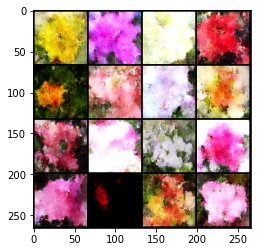

In [21]:
ddpm = DDPM(eps_model=NaiveUnet(3, 3, n_feat=128), betas=(1e-4, 0.02), n_T=1000) # 3 входных канала, 3 выходных, 128 фич, значения беты и количество шагов, как из ориганльной статьи
ddpm.to("cuda:0")
ddpm.load_state_dict(torch.load("ddpm_Flowers128.pth"))
ddpm.eval()
with torch.no_grad():
    sampled_img = ddpm.sample(16, (3, 64, 64), "cuda:0") # здесь размер 3*64*64 у торча C*H*W 
grid = make_grid(sampled_img, normalize=True, value_range=(-1, 1),  nrow=4)
plt.imshow(((grid.permute(1, 2, 0))).to('cpu').numpy())

# Ну имприссионисты точно останутся без работы